In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tf
import seaborn as sns

In [2]:
bag = rosbag.Bag('/home/uware/rosbags/dynamic/rotational/roll/3m/36h11.bag')

# create variables
target = 'is_detected'

# we are interested if tag is detected at 90°/s

In [3]:
topic = '/tag_detections'

rows = []
false_positives = []

# z distance to make sure its not fp
range = (2.7, 3.3)

for topic, msg, t in bag.read_messages(topics=topic):
    time = t
    is_detected = len(msg.detections)

    if is_detected==1:
        position = msg.detections[0].pose.pose.pose.position
        if range[0] < position.z < range[1]:
            orientation_quat = msg.detections[0].pose.pose.pose.orientation
            pitch, yaw, roll = tf.transformations.euler_from_quaternion([orientation_quat.x,orientation_quat.y,orientation_quat.z,orientation_quat.w], axes='rxyz')
            row={'time': time.to_sec(), target: is_detected, 'roll': np.degrees(roll), 'distance': position.z}
        else:
            false_positives.append(msg.detections[0])

    elif is_detected>1:
        for detection in msg.detections:
            position = detection.pose.pose.pose.position
            if range[0] < position.z < range[1]:
                orientation_quat = detection.pose.pose.pose.orientation
                pitch, yaw, roll = tf.transformations.euler_from_quaternion([orientation_quat.x,orientation_quat.y,orientation_quat.z,orientation_quat.w], axes='rxyz')
                row={'time': time.to_sec(), target: 1, 'roll': np.degrees(roll), 'distance': position.z}
            else:
                false_positives.append(detection)
                
    elif is_detected==0:
        row={'time': time.to_sec(), target: is_detected, 'roll': None}
    rows.append(row)

df = pd.DataFrame.from_records(rows)
print(len(false_positives))


0


In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df.groupby(target).head(2)

,is_detected,roll,distance,relative_time
0,1,23.837171,3.054386,0.00000
1,1,-15.853866,3.061301,1.06917


In [5]:
df.roll.describe()

count    177.000000
mean      -3.798271
std       23.990844
min      -40.631862
25%      -25.350569
50%       -6.797628
75%       15.126931
max       37.271715
Name: roll, dtype: float64

In [6]:
df.roll.max() - df.roll.min()

77.90357730948568

In [7]:
# ratio of detected to not
ratios = df.is_detected.value_counts(normalize=True)*100
ratios

1    100.0
Name: is_detected, dtype: float64

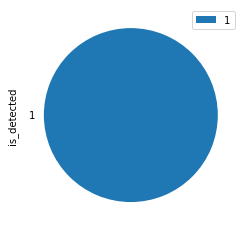

In [8]:
ratios.plot.pie()
plt.legend()

In [9]:
df.head(5)

,is_detected,roll,distance,relative_time
0,1,23.837171,3.054386,0.000000
1,1,-15.853866,3.061301,1.069170
2,1,19.528561,3.064267,1.819006
3,1,-11.023324,3.058611,2.795376
4,1,28.120231,3.067671,3.480170


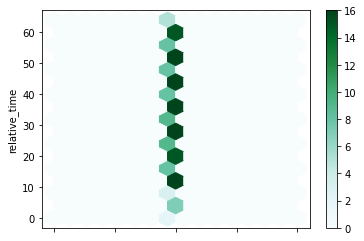

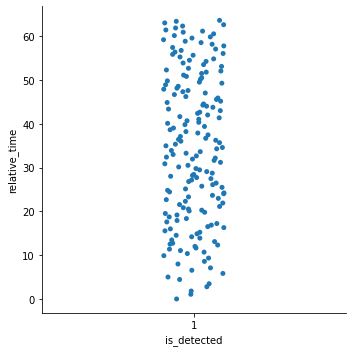

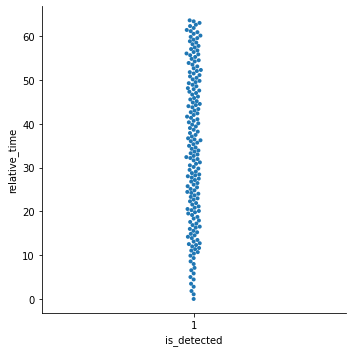

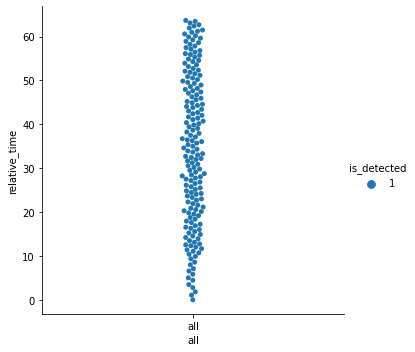

In [10]:
df.plot.hexbin(x=target, y="relative_time", gridsize=15)
sns.catplot(x=target, y='relative_time', data=df)
sns.catplot(x=target, y='relative_time', data=df, kind="swarm", s=4) # s=size of markers causes warnings when >4

# creating a dummy column for plotting both classes together
df.loc[:,'all'] = 'all'
sns.catplot(x='all', y='relative_time', data=df, hue=target, kind="swarm")

In [11]:
df.roll.describe()

count    177.000000
mean      -3.798271
std       23.990844
min      -40.631862
25%      -25.350569
50%       -6.797628
75%       15.126931
max       37.271715
Name: roll, dtype: float64